In [1]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
for package in ['pandas', 'seaborn']:
    print(sys.modules[package].__name__, sys.modules[package].__version__)

pandas 0.22.0
seaborn 0.8.1


---
## Load samples metadata

In [3]:
samples_df = pd.read_csv('./Supp_TableS1_metagenomes_data.csv')

In [4]:
samples_df.head()

,Depth,accession,environment,fraction,group,sample_group,size
0,50.0,ERR594415,marine,VIRUS,SAO,TARA_068,40938660.0
1,30.0,ERR594414,marine,VIRUS,IO,TARA_065,28140396.0
2,5.0,ERR594411,marine,VIRUS,SAO,TARA_078,38151334.0
3,5.0,ERR594410,marine,VIRUS,RS,TARA_031,36430030.0
4,80.0,ERR594413,marine,VIRUS,IO,TARA_042,60004302.0


In [5]:
metadata_df_slim = samples_df[['Depth', 'accession', 'environment', 'fraction', 'group',
       'sample_group']]

- XXR (xiangxi river): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342553/

---
## Load rhodopsins metadata

In [6]:
genes_df = pd.read_csv('./Supp_TableS2_rhodopsins_data.csv')

In [7]:
genes_df.head()

,protein,rhodopsin_type,cluster,avg_cluster_length,protein_sequence,protein_length
0,TM7_genomosp_GTL1,helio,helio_5,0.761375,KITTTKLRKFNVAMAVLHAVQGFLILWLSRSFDLPIMGSYLEFNRQ...,251
1,Halovivax_asiaticus,helio,helio_5,0.761375,APEYRRLRRWNAVMAVLHFVQGALMVVFAESIQWPITRTRYEFDVA...,252
2,Mesotoga_infera,helio,helio_5,0.761375,ESVYKKLRIYNLIMGLLHLVQGIIMLIVSNDSSLTITRNYLEFNQE...,252
3,Halobacterium_DL1,helio,helio_5,0.761375,SARDSRLRLWNSVMAVLHFLQGAAMVLLADTVLWPITRTRYGFDPG...,252
4,Halorhabdus_tiamatea,helio,helio_5,0.761375,PSDWNLRRFNAAMAVLHFLQGALMVYLSSSREWTITAVYQEFDTTT...,251


---
## Load diamond results

In [8]:
df_dmnd = pd.read_csv('./diamond_results.2017-10-01.csv')

In [9]:
df_dmnd.head()

,accession,reads_aln,unique_aln,non_unique_aln,amb,non_rh,type_1,helio,1_1,1_2,1_3,1_4,helio_1,helio_2,helio_3,helio_4,helio_5,helio_6
0,ERR1474560,661,661,661,0,1,114,546,114,0,0,0,0,0,0,24,0,522
1,ERR1474561,365,365,365,0,0,146,219,146,0,0,0,0,1,0,10,1,207
2,ERR1474559,323,323,323,0,0,91,232,89,0,2,0,0,0,0,7,0,225
3,ERR1474558,1906,1906,1906,0,8,435,1463,435,0,0,0,0,0,0,63,1,1399
4,ERR1474562,609,609,609,0,0,324,285,323,1,0,0,0,0,0,19,0,266


---

# calculate per million scaling factor

In [10]:
samples_df['SF'] = samples_df['size']/1000000

---

In [11]:
rh_counts_columns = ['accession',
 '1_1',
 '1_2',
 '1_3',
 '1_4',
 'helio_1',
 'helio_2',
 'helio_3',
 'helio_4',
 'helio_5',
 'helio_6']

In [12]:
rh_counts = df_dmnd[rh_counts_columns].\
melt(id_vars='accession', var_name='cluster' ,value_name='count').copy()

In [13]:
rh_counts = rh_counts.merge(samples_df, on='accession', how='left')

In [14]:
rh_counts['RPM'] = rh_counts['count']/rh_counts['SF']

In [15]:
rh_counts = rh_counts.merge(genes_df[['cluster', 'avg_cluster_length']].drop_duplicates(), on='cluster', how='inner')

In [16]:
rh_counts['RPKM'] = rh_counts['RPM']/rh_counts['avg_cluster_length']

---

In [17]:
rh_major = rh_counts[['accession','cluster', 'RPKM']].copy()

In [18]:
rh_major['rh_type'] = rh_counts['cluster'].apply(lambda x: x.split('_')[0])

In [19]:
rh_major = rh_major.groupby(['accession', 'rh_type']).agg(sum).reset_index()

---

In [20]:
# add metadata
rh_major = rh_major.merge(metadata_df_slim, on='accession', how='left')


In [21]:
rh_major.loc[rh_major["group"]!="marine"].head()

,accession,rh_type,RPKM,Depth,environment,fraction,group,sample_group
0,ERR1035442,1,0.357235,5.0,River,BACT,QRE,QRS_NN6
1,ERR1035442,helio,35.297510,5.0,River,BACT,QRE,QRS_NN6
2,ERR1474558,1,20.055517,NaN,xiangxi-river,NaN,XXR,XXR_XXR_E
3,ERR1474558,helio,62.471220,NaN,xiangxi-river,NaN,XXR,XXR_XXR_E
4,ERR1474559,1,4.200130,NaN,xiangxi-river,NaN,XXR,XXR_XXR_M


---

Generate lists to order the different regions in the plot.

In [22]:
order_df = rh_major.loc[rh_major['environment']!= 'marine'].groupby(['group', 'rh_type']).agg(median).reset_index()

In [23]:
non_tara = list(order_df.loc[order_df['rh_type']=='helio'].sort_values(by='RPKM')['group'].values)

#### empty boxplot with individual points on top

/Users/jfloresu/.virtualenvs/jupyter/lib/python3.6/site-packages/seaborn/categorical.py:1407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


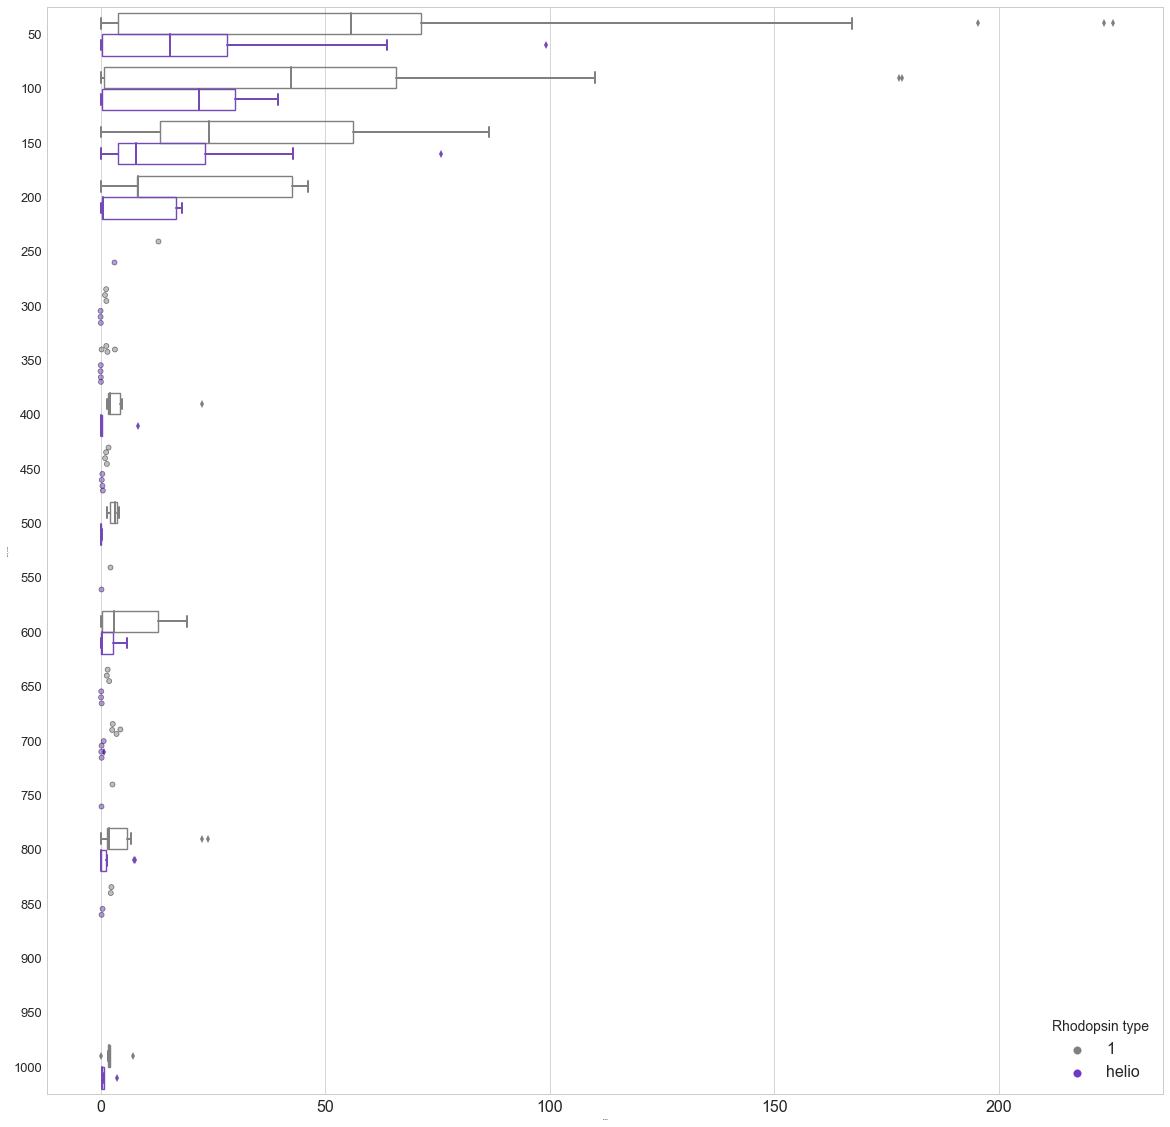

In [26]:
plot_df_ = rh_major.copy()
plot_df_ = plot_df_.loc[plot_df_['RPKM'] >= 0]
plot_df_ = plot_df_.loc[plot_df_['environment'] == 'marine']
#plot_df_ = plot_df_.loc[plot_df_['Depth'].isin([150,30])]

depth_group_sizes = plot_df_.groupby(['Depth']).agg('size').reset_index()
depth_group_sizes.rename(columns={0:'size'}, inplace=True)
#depth_group_sizes = depth_group_sizes.loc[depth_group_sizes['size']>=5]

plot_df_ = plot_df_.loc[plot_df_['Depth'].isin(depth_group_sizes['Depth'].unique())]

bin_df = pd.DataFrame(pd.cut(plot_df_['Depth'], bins=range(0,1050, 50))).rename(columns={'Depth':'bin'})
bin_df['depth_group'] = bin_df['bin'].apply(lambda x: x.right)
plot_df_ = pd.concat([bin_df['depth_group'], plot_df_], axis=1)

sns.set_context("paper", font_scale=2)
sns.set_style('whitegrid')
sns.despine()

color_dict = {'helio':"#7137c8", '1':"gray"}

mpl.rc("figure", figsize=(14,10))
plt.rcParams["axes.labelsize"] = 2

ax = sns.boxplot("RPKM", "depth_group","rh_type", data=plot_df_, orient='h', palette=color_dict, width=0.8)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)# whiskers
        line.set_mfc(col)# outliers (fliers)
        line.set_mec(col)# ?
        line.set_linewidth(2)

#remove boxplots with less than 5 points
# group by type and region, then count how many members are in each group
group_size = plot_df_.groupby(['rh_type', 'depth_group']).size().reset_index()
group_size.rename(columns={0:'size'}, inplace=True)
#order the size df using the same order as boxes in the plot
group_size = group_size.set_index('depth_group').loc[sorted(plot_df_['depth_group'].unique())]
group_size.reset_index(inplace=True)
#hide boxes for groups with less than 5 samples
for i, row in group_size.iterrows():
    if row['size'] < 5:
        ax.artists[i].set_visible(False)
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_linewidth(0)

swarmplot_depths = group_size.loc[group_size['size']>=5]
swarmplot_df = plot_df_.copy()
swarmplot_df.loc[plot_df_['depth_group'].isin(swarmplot_depths['depth_group'].unique()), 'RPKM'] = pd.np.nan
# add swarmplot
ax = sns.swarmplot("RPKM", "depth_group", "rh_type", data=swarmplot_df, \
                   palette=color_dict, orient='h', dodge=True, size=5, \
                   edgecolor="black", linewidth=0.75, alpha=.5)
depths = sorted(swarmplot_df['depth_group'].unique())

# Set legend parameters
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title='Rhodopsin type')
plt.setp(ax.get_legend().get_title(), fontsize=14) #set legend font size

#set ticks font size
ax.tick_params(axis='y', which='major', labelsize=13)
#ax.tick_params(axis='y', which='minor', labelsize=8)

fig = ax.get_figure()
#fig.savefig('./abundance_depth_ranges.tiff', bbox_inches="tight", dpi=300)#,pad_inches=1)
plt.show()


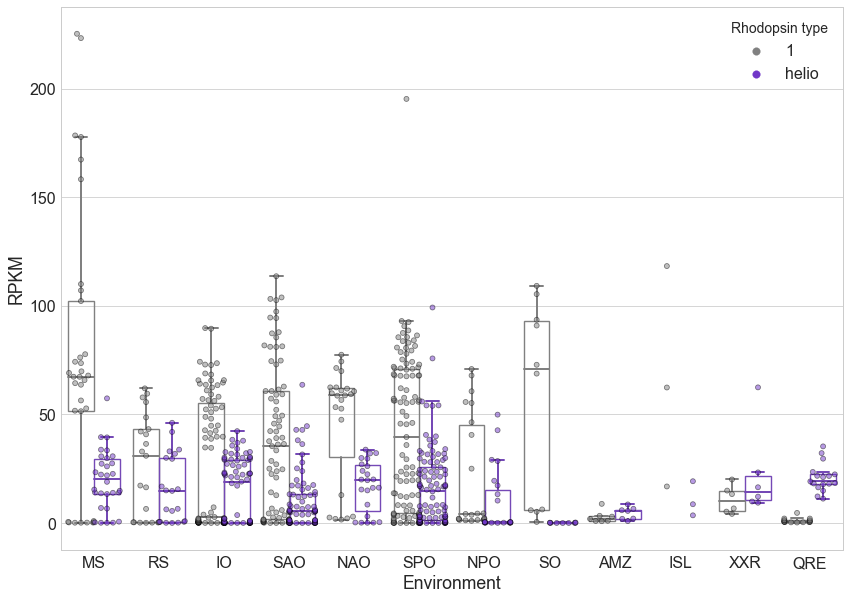

In [25]:
plot_df_ = rh_major.copy()
plot_df_ = plot_df_.loc[plot_df_['RPKM'] > 0]

column_order = ['MS', 'RS', 'IO', 'SAO',  'NAO', 'SPO', 'NPO', 'SO'] + non_tara

sns.set_context("paper", font_scale=2)
sns.set_style("whitegrid")
sns.despine()

#color_dict = {'3':"white", '1':"white"}
color_dict = {'helio':"#7137c8", '1':"gray"}
#color_dict_swarm = {'3':"#7137c8", '1':"gray"}

mpl.rc("figure", figsize=(20,20))

ax = sns.boxplot("group", "RPKM", "rh_type", data=plot_df_, palette=color_dict, order=column_order, fliersize=0)

for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)# whiskers
        line.set_mfc(col)# outliers (fliers)
        line.set_mec(col)# ?
        line.set_linewidth(2)
    
#remove boxplots with less than 5 points
# group by type and region, then count how many members are in each group
group_size = plot_df_.groupby(['rh_type', 'group']).size().reset_index()
group_size.rename(columns={0:'size'}, inplace=True)
#order the size df using the same order as boxes in the plot
group_size = group_size.set_index('group').loc[column_order]
group_size.reset_index(inplace=True)
#hide boxes for groups with less than 5 samples
for i, row in group_size.iterrows():
    if row['size'] < 5:
        ax.artists[i].set_visible(False)
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_linewidth(0)
        
# add swarmplot
ax = sns.swarmplot("group", "RPKM", "rh_type", data=plot_df_, \
                   palette=color_dict, order=column_order, dodge=True, size=5, \
                   edgecolor="black", linewidth=0.75, alpha=.5)
ax.set(xlabel='Environment')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title='Rhodopsin type')

plt.setp(ax.get_legend().get_title(), fontsize=14)

#fig = ax.get_figure()
#fig.set_axesset_axis_labels("Region", "RPKM").set_titles("Rhodopsin {col_name}")
#fig.savefig("./abundance_50.eps")
#fig.savefig('./abundance_50.tiff', bbox_inches="tight", dpi=300)#,pad_inches=1)


plt.show()

            